In [207]:
import cv2
import numpy as np
from pandas import DataFrame, read_csv
from matplotlib import pyplot as plt
from shutil import copy2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten,
                                     GlobalMaxPooling2D, LeakyReLU, concatenate, Dropout,
                                     AveragePooling2D, AveragePooling3D, MaxPooling3D)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam, Adamax
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from os.path import isfile
from tqdm.notebook import tqdm
import itertools

In [208]:
SEED = 42

In [209]:
X = np.load('../project1/X.npy')
Y = np.load('../project1/Y.npy')

In [210]:
X.shape

(2062, 64, 64)

In [211]:
X = np.stack(3*[X],axis=3)

In [212]:
X.shape, Y.shape

((2062, 64, 64, 3), (2062, 10))

In [213]:
Ydf = DataFrame(data=Y, columns=[9-x for x in range(10)])
Ydf = Ydf[[x for x in range(10)]].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, Ydf, test_size=0.3, random_state=42)
Ydf.shape, X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((2062, 10), (1443, 64, 64, 3), (619, 64, 64, 3), (1443, 10), (619, 10))

In [214]:
train_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.1, horizontal_flip=True,
                                   vertical_flip=True)
train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=50,
        shuffle=False,
        seed=SEED)

In [215]:
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow(
        X_valid, y_valid,
        batch_size=50,
        shuffle=False,
        seed=SEED)

In [216]:
input_shape = (64,64)

In [217]:
def create_pretrained_model(input_shape):
    
    model = DenseNet121(include_top=False, input_shape=input_shape)
    output = model.get_layer('pool4_pool').output
    #output = MaxPooling2D(pool_size=(2,2))(output)

    
#     model = VGG16(include_top=False, input_shape=input_shape)
#     output = model.layers[-1].output
#     output = AveragePooling2D(pool_size=(3,3))(output)
    
    output = Flatten()(output)
    
    model = Model(model.input, output)
    
    #model.trainable = False
    for layer in model.layers:
        layer.trainable = False
    return model

In [218]:
model = create_pretrained_model((input_shape[0],input_shape[1],3))

In [219]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2 (None, 70, 70, 3)    0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_12[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [220]:
def get_features(model, datagen, multiplier=1):
    nb_samples = datagen.n
    
    batches = 0
    
    y_list = []
    feature_list = [] 
    
    for batch in tqdm(range(multiplier * (nb_samples // datagen.batch_size))):
        x_batch, y_batch = datagen.next()
        y_batch_pred = model.predict(x_batch)
        
        feature_list.append(y_batch_pred)
        y_list.append(y_batch)

    highlvl_features = np.concatenate(feature_list)
    y = np.concatenate(y_list)
#     highlvl_features = model.predict_generator(datagen, nb_samples*multiplier)
    
#     bacth_size_old = datagen.batch_size
#     datagen.batch_size = nb_samples
#     y = train_generator.next()[1]
#     y = np.tile(y,multiplier)
#     datagen.batch_size = bacth_size_old
    
    return highlvl_features, y

In [221]:
features_train_file = 'TL-features-train.npy'
features_valid_file = 'TL-features-valid.npy'
y_train_file = 'TL-y-train.npy'
y_valid_file = 'TL-y-valid.npy'

In [222]:
if isfile(features_train_file):
    features_train = np.load(features_train_file, allow_pickle=True)
    features_valid = np.load(features_valid_file, allow_pickle=True)
    y_train = np.load(y_train_file, allow_pickle=True)
    y_valid = np.load(y_valid_file, allow_pickle=True)
else:
    features_train, y_train = get_features(model, train_generator, 20)
    features_valid, y_valid = get_features(model, valid_generator)
    
    np.save(features_train_file, features_train, allow_pickle=True)
    np.save(features_valid_file, features_valid, allow_pickle=True)
    np.save(y_train_file, y_train, allow_pickle=True)
    np.save(y_valid_file, y_valid, allow_pickle=True)

In [223]:
def create_toplvl_model(input_shape):
    return Sequential([
        Input(shape=input_shape),
        
        Dropout(0.1),
        
        Dense(32),
        Activation('relu'),
        Dense(16),
        Activation('relu'),
        Dense(10),
        Activation('softmax')
])

In [224]:
features_train.shape, y_train.shape, features_valid.shape, y_valid.shape

((27867, 2048), (27867, 10), (600, 2048), (600, 10))

In [225]:
toplvl_input_shape = model.output_shape[1]
top_model = create_toplvl_model(toplvl_input_shape)
toplvl_input_shape

2048

In [226]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

loss='categorical_crossentropy'
LEARNING_RATE = 0.05
BATCH_SIZE = 50
EPOCHS = 50
                             
#model.compile(loss=loss, optimizer='adamax', metrics=[root_mean_squared_error])
top_model.compile(loss=loss, batch_size=BATCH_SIZE, optimizer='nadam', metrics=['acc',root_mean_squared_error])

In [227]:
history = top_model.fit(x=features_train, y=y_train, epochs=EPOCHS, validation_data=(features_valid, y_valid),
                    verbose=1)

Train on 27867 samples, validate on 600 samples
Epoch 1/50
27867/27867 [==============================] - 3s 123us/sample - loss: 0.8716 - acc: 0.7105 - root_mean_squared_error: 0.1953 - val_loss: 0.4625 - val_acc: 0.8417 - val_root_mean_squared_error: 0.1478
Epoch 2/50
27867/27867 [==============================] - 3s 95us/sample - loss: 0.4077 - acc: 0.8635 - root_mean_squared_error: 0.1407 - val_loss: 0.4061 - val_acc: 0.8550 - val_root_mean_squared_error: 0.1385
Epoch 3/50
27867/27867 [==============================] - 3s 98us/sample - loss: 0.3138 - acc: 0.8954 - root_mean_squared_error: 0.1230 - val_loss: 0.3278 - val_acc: 0.8933 - val_root_mean_squared_error: 0.1255
Epoch 4/50
27867/27867 [==============================] - 3s 96us/sample - loss: 0.2617 - acc: 0.9134 - root_mean_squared_error: 0.1116 - val_loss: 0.3395 - val_acc: 0.8867 - val_root_mean_squared_error: 0.1259
Epoch 5/50
27867/27867 [==============================] - 3s 97us/sample - loss: 0.2299 - acc: 0.9251 - roo

27867/27867 [==============================] - 3s 96us/sample - loss: 0.0753 - acc: 0.9724 - root_mean_squared_error: 0.0569 - val_loss: 0.2481 - val_acc: 0.9283 - val_root_mean_squared_error: 0.0951
Epoch 40/50
27867/27867 [==============================] - 3s 104us/sample - loss: 0.0763 - acc: 0.9720 - root_mean_squared_error: 0.0567 - val_loss: 0.1913 - val_acc: 0.9383 - val_root_mean_squared_error: 0.0901
Epoch 41/50
27867/27867 [==============================] - 3s 105us/sample - loss: 0.0752 - acc: 0.9728 - root_mean_squared_error: 0.0559 - val_loss: 0.2325 - val_acc: 0.9317 - val_root_mean_squared_error: 0.0940
Epoch 42/50
27867/27867 [==============================] - 3s 105us/sample - loss: 0.0744 - acc: 0.9723 - root_mean_squared_error: 0.0567 - val_loss: 0.1993 - val_acc: 0.9400 - val_root_mean_squared_error: 0.0853
Epoch 43/50
27867/27867 [==============================] - 3s 108us/sample - loss: 0.0713 - acc: 0.9731 - root_mean_squared_error: 0.0553 - val_loss: 0.2336 - va

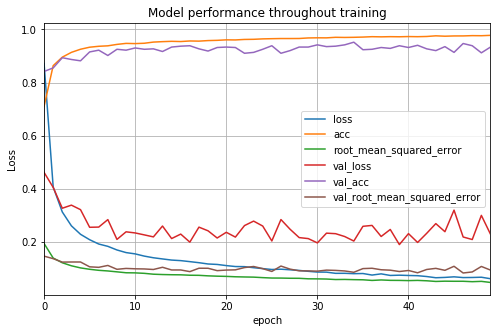

In [228]:
DataFrame(history.history).plot(figsize=(8, 5))#, logy=True)
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [229]:
y_pred = top_model.predict(features_valid)

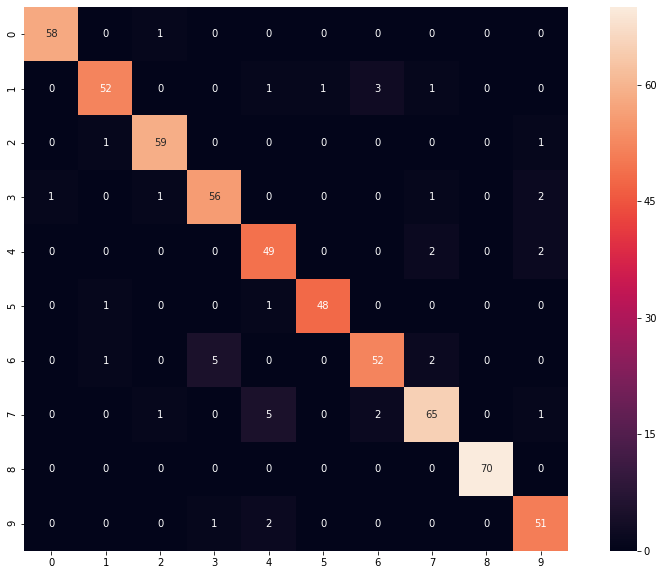

Accuracy= 0.9333333333333333


In [230]:
y_valid_class = y_valid.argmax(axis=1)
y_valid_pred_class = y_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_valid_class, y_valid_pred_class)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print('Accuracy=', accuracy_score(y_valid_class, y_valid_pred_class))

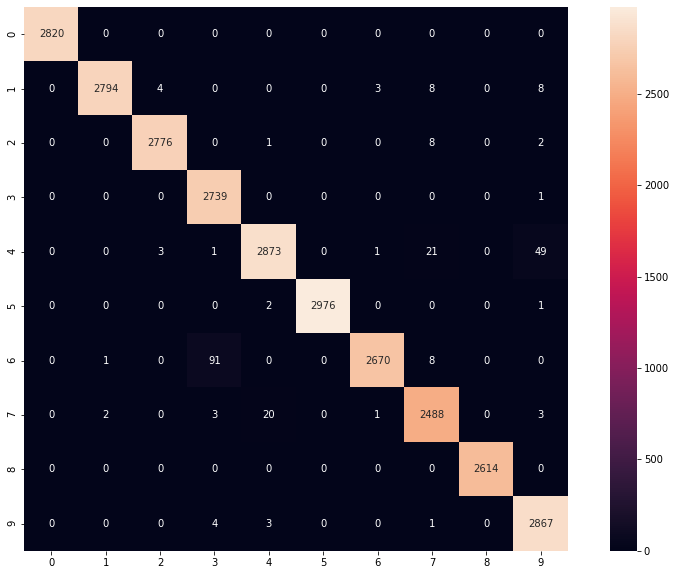

Accuracy= 0.9910288154447914


In [231]:
y_train_pred = top_model.predict(features_train)
y_train_class = y_train.argmax(axis=1)
y_train_pred_class = y_train_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_train_class, y_train_pred_class)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print('Accuracy=', accuracy_score(y_train_class, y_train_pred_class))